# Basic LSTM example for DS@HEP hands-on

**TODO** Add a description up here.

**TODO** Drop unnecessary pandas and use numpy directly

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib notebook

### Loading the data

Change this to point to whichever dataset you want to use.

In [2]:
filename = "public_train.csv"
df = pd.read_csv(filename)

In [3]:
# Build the arrays of input variables and track labels (cluster_id)
# by dropping everything else from the dataframe with a call to drop
y = df.drop(['layer','iphi','x','y'], axis=1).values
X = df.drop(['cluster_id'], axis=1).values

### Looping over events

In [4]:
y_events = y[:,0]
events = np.unique(y_events)

# Count the number of tracks
ntrack = 0
for ev in events:
    ntrack += np.unique(y[y_events==ev][:,1]).size

In [5]:
print('There are %d events' % events.shape[0])
print('There are %d total tracks' % ntrack)
print('There are %d total hits' % X.shape[0])
print('Average %g hits per track' % (float(X.shape[0]) / ntrack))
print('There are %d hits on first layer' % X[X[:,1]==0].shape[0])
print('There are %d hits on last layer' % X[X[:,1]==8].shape[0])

There are 5000 events
There are 49897 total tracks
There are 418059 total hits
Average 8.37844 hits per track
There are 48383 hits on first layer
There are 44654 hits on last layer


### Define the model

In [6]:
from sklearn.base import BaseEstimator
from sklearn.cluster import DBSCAN

from keras import layers, models

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using cuDNN version 5105 on context None
Mapped name None to device cuda4: GeForce GTX 1080 (0000:0B:00.0)


In [7]:
class det_geo():
    layer_r = np.array([39,85,155,213,271,405,562,762,1000])
    layer_pitch = np.array([0.025, 0.025, 0.025, 0.025, 0.025,
                            0.05, 0.05, 0.05, 0.05])
    num_layers = layer_r.shape[0]
    max_phi = (2 * np.pi * layer_r / layer_pitch + 1).astype(np.int)

def rescale_phi(phi, nbin, layer):
    return (phi * float(nbin) /
            det_geo.max_phi[layer.astype(np.int)]).astype(np.int)

def build_model(num_hidden, length, dim,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=(length, dim))
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [8]:
class Clusterer(BaseEstimator):
    def __init__(self, num_phi_bin=100, hidden_dim=50, batch_size=128, num_epoch=5):
        """
        LSTM model example.
        TODO: fill in more details.
        """
        self.num_phi_bin = num_phi_bin
        self.hidden_dim = hidden_dim
        self.model = build_model(self.hidden_dim,
                                 det_geo.layer_r.shape[0],
                                 self.num_phi_bin)
        self.batch_size = batch_size
        self.num_epoch = num_epoch

        self.train_input = None
        self.train_target = None
        self.prepared = False
    def prepare_data(self, X, y):
        if self.prepared: return
        self.prepared = True
        evids, layers, phis = (X[:,0].astype(np.int),
                               X[:,1].astype(np.int),
                               X[:,2].astype(np.int))
        phis = rescale_phi(phis, self.num_phi_bin, layers)
        unique_evids = np.unique(evids)
        num_event = unique_evids.shape[0]

        # Count the number of first-layer hits, which will be my seeds
        seed_idx = np.where(layers == 0)[0]
        num_seeds = seed_idx.size
        print('Number of seeds: %d' % num_seeds)
        print('Preparing training data...')
        # Training input will contain the seed hit followed by the rest of the event
        self.train_input = np.zeros((num_seeds, det_geo.num_layers,
                                     self.num_phi_bin))
        # Training targets will be images of the individual signal tracks
        self.train_target = np.zeros_like(self.train_input)

        # Loop over training samples to prepare (seeds)
        for i_sample in xrange(num_seeds):
            i_hit = seed_idx[i_sample]

            # Find all the hits from this event
            ev_idx = evids == y[i_hit,0]
            ev_lay, ev_phi = layers[ev_idx], phis[ev_idx]

            # Fill the input first layer with just the seed hit
            self.train_input[i_sample,0,phis[i_hit]] = 1
            # Fill the other layers with all remaining event hits
            self.train_input[i_sample, ev_lay[ev_lay>0], ev_phi[ev_lay>0]] = 1

            # Fill target with hits from this track
            ev_trkid = y[ev_idx][:,1]
            ev_trk_idx = ev_trkid == y[i_hit,1]
            self.train_target[i_sample, ev_lay[ev_trk_idx], ev_phi[ev_trk_idx]] = 1

    def fit(self, X, y):

        self.prepare_data(X, y)
        
        print('Starting training...')
        self.history = self.model.fit(
            self.train_input, self.train_target,
            batch_size=self.batch_size, nb_epoch=self.num_epoch,
            )

    def predict_single_event(self, X_event):

        # We need to now transform the data into the format
        # needed for my algorithm
        lays, phis = (X_event[:,0].astype(np.int),
                      X_event[:,1].astype(np.int))
        # Rebin phi
        phis = rescale_phi(phis, self.num_phi_bin, lays)

        # First, find the seeds
        seed_idx = np.where(lays == 0)[0]
        num_seeds = seed_idx.size

        # Prepare the model inputs
        self.test_input = np.zeros((num_seeds, det_geo.num_layers,
                                    self.num_phi_bin))

        # Loop over seeds to prepare
        for i_sample in xrange(num_seeds):
            i_hit = seed_idx[i_sample]

            # Fill the input first layer with just the seed hit
            self.test_input[i_sample, 0, phis[i_hit]] = 1
            # Fill the other layers with all remaining event hits
            self.test_input[i_sample, lays[lays>0], phis[lays>0]] = 1

        # Run the model prediction
        self.test_pred = self.model.predict(self.test_input)

        # Now we need to loop over all hits and decide which
        # track they belong to
        trkid = np.zeros(X_event.shape[0])
        for i in xrange(trkid.shape[0]):
            lay, phi = lays[i], phis[i]

            # Get the list of track scores
            scores = self.test_pred[:, lays[i], phis[i]]
            #print 'scores:', scores

            # Select the best score
            best = np.argmax(scores)

            # If the best isn't good enough, it's possible that
            # a track was missing a hit on the first layer.
            # We may be able to improve score by assigning all such
            # tracks to a new class (rather than 'unassigned')
            if scores[best] < 1 / float(self.num_phi_bin):
                best = scores.shape[0]

            trkid[i] = best

        return trkid

In [9]:
tracker = Clusterer()

#### Training the algorithm

In [10]:
tracker.fit(X, y)

Number of seeds: 48383
Preparing training data...
Starting training...
Epoch 1/5
48383/48383 [==============================] - 3s - loss: 3.2717 - acc: 0.3508     
Epoch 2/5
48383/48383 [==============================] - 2s - loss: 1.6910 - acc: 0.6265     
Epoch 3/5
48383/48383 [==============================] - 2s - loss: 1.1410 - acc: 0.6755     
Epoch 4/5
48383/48383 [==============================] - 2s - loss: 0.9021 - acc: 0.6954     
Epoch 5/5
48383/48383 [==============================] - 2s - loss: 0.7421 - acc: 0.7221     


#### Running the algorithm to reconstruct the tracks in data
This will take some time to go through all events

In [11]:
import random
ievent= random.choice( X[:,0] )
event_indices = X[:,0]==ievent
X_event = X[event_indices,1:] # event_id column dropped
pixelx = X_event[:,2]
pixely = X_event[:,3]
particles = y[event_indices][:,1]

In [12]:
y_true = y
y_predicted = tracker.predict_single_event(X_event)

Visualize for that particular event

In [13]:
from utils import display

<IPython.core.display.Javascript object>


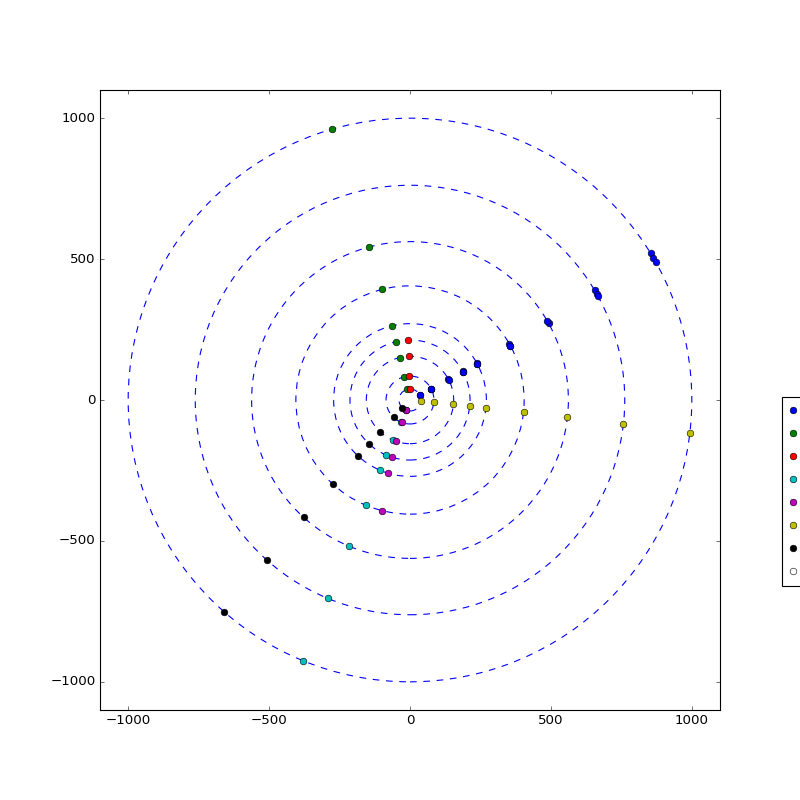

In [14]:
display(pixelx, pixely, y_predicted)

### Scoring the assignment

In [15]:
from utils import score_function

Check the score of a single event:

In [16]:
y_pred = np.zeros((len(y_predicted),2))

y_pred[:,1] = y_predicted
y_pred[:,0] = [ievent] * len(y_predicted)

y_test_event = y[y[:,0]==ievent]

score_function(y_test_event,y_pred)

0.782608695652174

Let's continue training this model

In [20]:
for t in range(10):
    tracker.fit(X, y)
    y_predicted = tracker.predict_single_event(X_event)
    y_pred = np.zeros((len(y_predicted),2))

    y_pred[:,1] = y_predicted
    y_pred[:,0] = [ievent] * len(y_predicted)

    y_test_event = y[y[:,0]==ievent]

    s = score_function(y_test_event,y_pred)
    print ("Score is:", s)

Starting training...
Epoch 1/5
48383/48383 [==============================] - 2s - loss: 0.1105 - acc: 0.8948     
Epoch 2/5
48383/48383 [==============================] - 2s - loss: 0.1094 - acc: 0.8952     
Epoch 3/5
48383/48383 [==============================] - 2s - loss: 0.1088 - acc: 0.8951     
Epoch 4/5
48383/48383 [==============================] - 2s - loss: 0.1084 - acc: 0.8950     
Epoch 5/5
48383/48383 [==============================] - 2s - loss: 0.1088 - acc: 0.8951     
Score is: 0.782608695652
Starting training...
Epoch 1/5
48383/48383 [==============================] - 2s - loss: 0.1077 - acc: 0.8955     
Epoch 2/5
48383/48383 [==============================] - 2s - loss: 0.1066 - acc: 0.8958     
Epoch 3/5
48383/48383 [==============================] - 2s - loss: 0.1051 - acc: 0.8961     
Epoch 4/5
48383/48383 [==============================] - 2s - loss: 0.1056 - acc: 0.8961     
Epoch 5/5
48383/48383 [==============================] - 2s - loss: 0.1052 - acc: 0.896